In [44]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib

In [45]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, distinct

In [47]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False)

In [48]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)



In [49]:
# inspector job :-)  This allows the inspection of database tables from my Python code
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [50]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [52]:
# Use SQLAlchemy reflection to get the details of the Measurement table
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [53]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [54]:
# How many measurement dates does the data in this table cover?
# This will tell me the total number of rows of measurement data (but not the unique dates those observations were taken)
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [55]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)


2017-08-23 00:00:00


In [56]:
# Calculate the date 1 year prior to the last data point in the database
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()


# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head()


,precipitation_amount
measurement_date,
2016-08-24,236.9
2016-08-25,13.6
2016-08-26,2.6
2016-08-27,8.1
2016-08-28,78.9


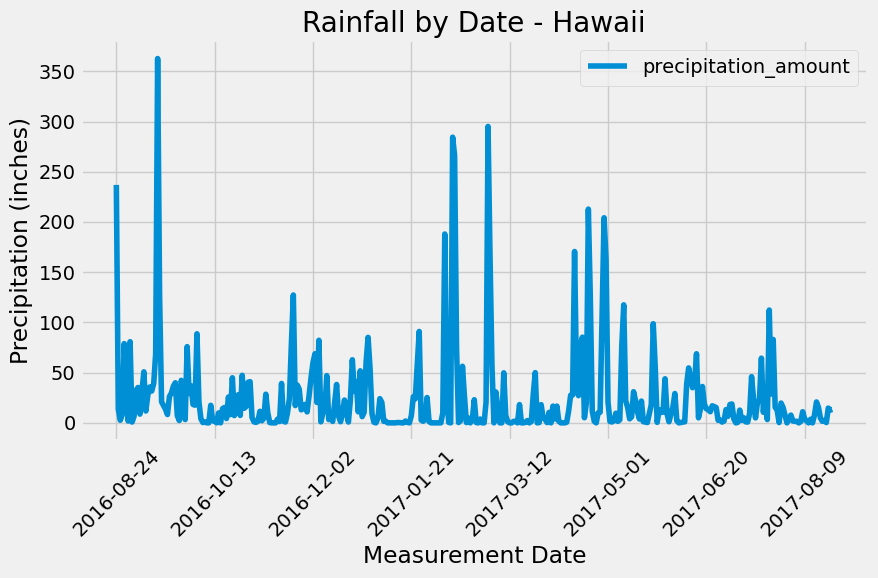

In [65]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(rot=45, title = "Rainfall by Date - Hawaii", xlabel='Measurement Date', ylabel = "Precipitation (inches)", figsize=(9,6))
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.show()
ax.figure.savefig('Annual_Precipitation_Hawaii.png', bbox_inches='tight')

In [66]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,365.000000
mean,24.760274
std,45.113719
min,0.000000
25%,1.400000
50%,10.100000
75%,27.500000
max,362.700000


# Exploratory Station Analysis

In [67]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [68]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 12.2, 29.4, 22.03582251082252)


In [71]:
# Using the most active station id
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
station_temps_df.head()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


,Measurement Date,Temperature
0,2016-08-24,25.0
1,2016-08-25,26.7
2,2016-08-26,26.7
3,2016-08-27,23.9
4,2016-08-28,22.8


# Close Session

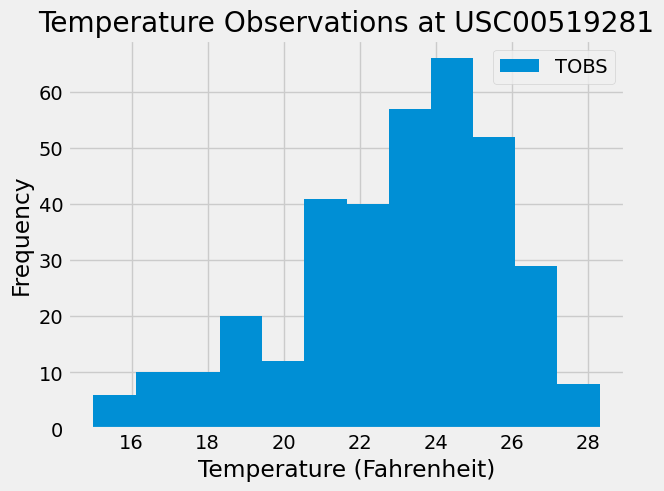

In [75]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

In [76]:
# Close Session
session.close()